# Line Segmentation
**The algorithm consists of the following steps**:
* Grayscaling
* Thresholding
* Dilation
* Finding Contours
* Non Maximum Supression

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

**Download a sample Image**

In [2]:
!curl https://images.sampletemplates.com/wp-content/uploads/2016/12/21102637/Technical-Business-Document.jpg --output doc.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  177k  100  177k    0     0  1323k      0 --:--:-- --:--:-- --:--:-- 1323k


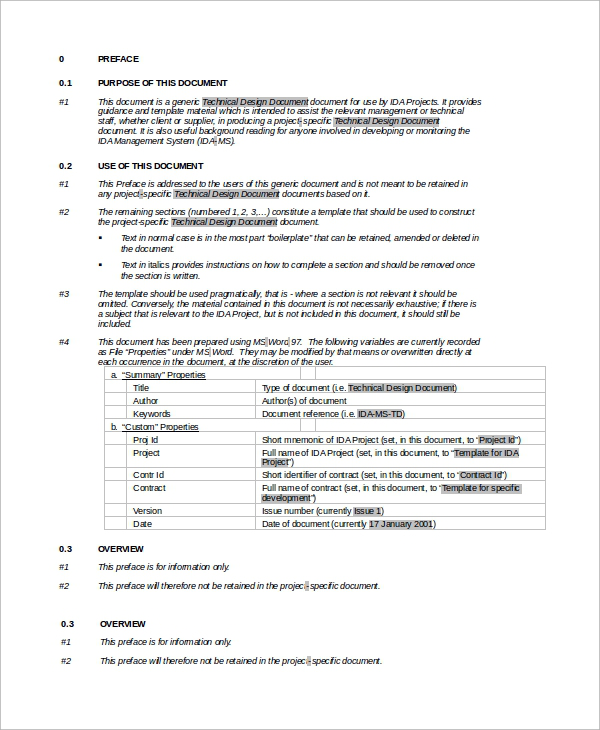

In [3]:
doc = Image.open('./doc.jpg')
doc

**Utility functions**

In [4]:
def display_image(image, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    fig.suptitle(title, fontsize=18)

In [5]:
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

## Grayscaling

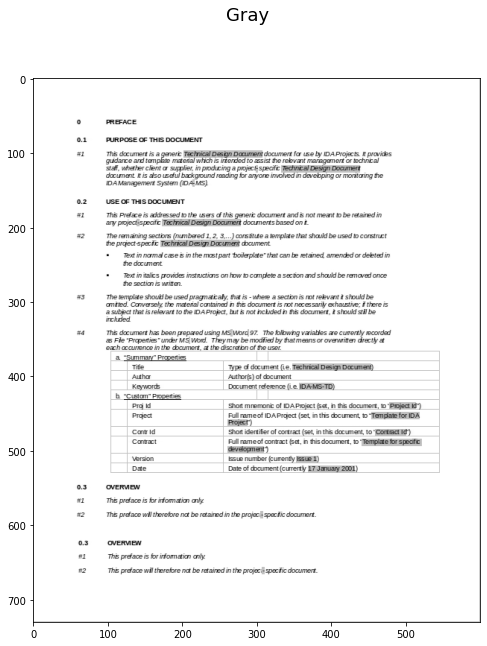

In [6]:
doc = np.array(doc)
gray = cv2.cvtColor(doc,cv2.COLOR_RGB2GRAY)
display_image(gray, 'Gray')

## Thresholding

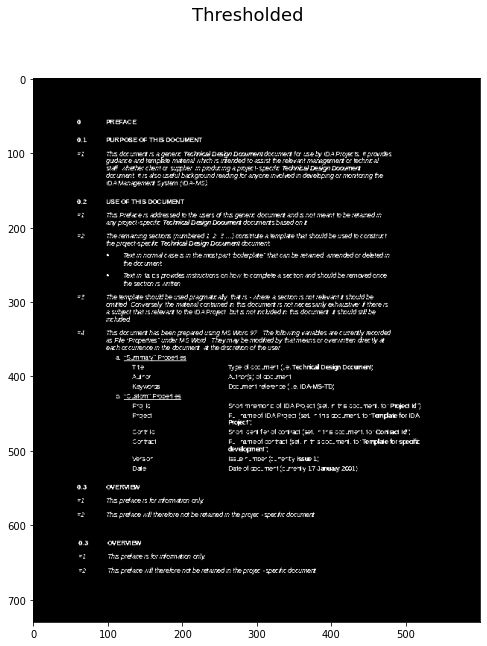

In [7]:
ret,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)
display_image(thresh, 'Thresholded')

## Dilation

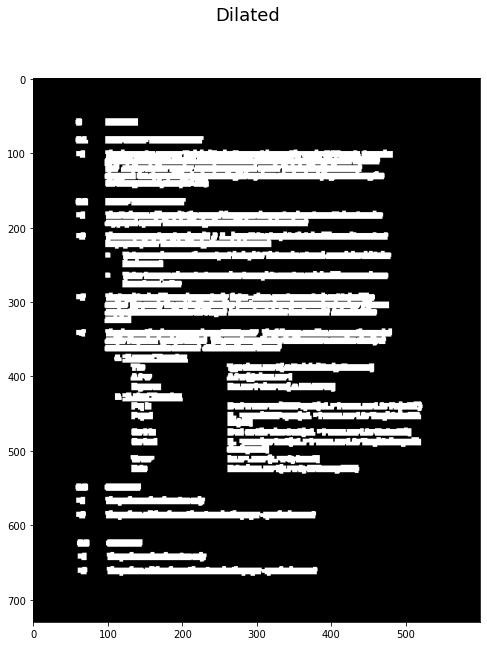

In [8]:
kernel = np.ones((5,5), np.uint8) # play around with the kernel size to get the desired results
img_dilation = cv2.dilate(thresh, kernel, iterations=1)
display_image(img_dilation, 'Dilated')

## Contours and NMS

In [9]:
#find contours
ctrs, hier = cv2.findContours(img_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

bbox = []
img_copy = doc.copy()

for i, ctr in enumerate(sorted_ctrs):
    x, y, w, h = cv2.boundingRect(ctr)
    bbox.append((x,y,x+w,y+h))
    cv2.rectangle(doc,(x,y),( x + w, y + h ),(90,0,255),2)

# bbox = [(x, y, x+w, y+h) for (x, y, w, h) in bbox]
# bbox
nms_boxes = non_max_suppression_fast(np.array(bbox), 0.3)


for x1,y1,x2,y2 in nms_boxes:
    cv2.rectangle(img_copy, (x1,y1), (x2,y2), (0,90,255), 2)

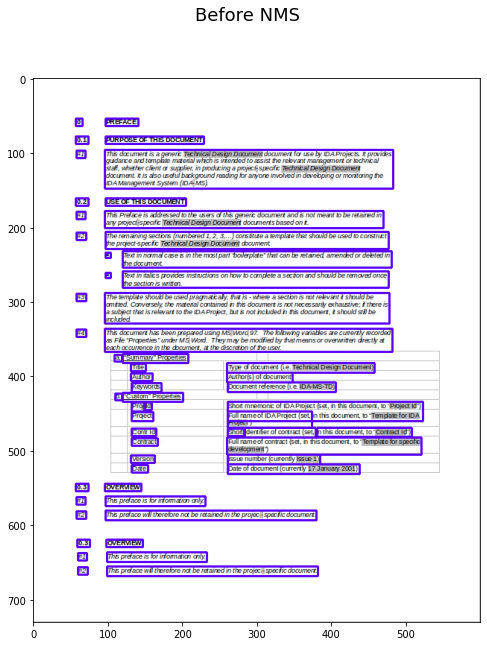

In [10]:
display_image(doc, 'Before NMS')

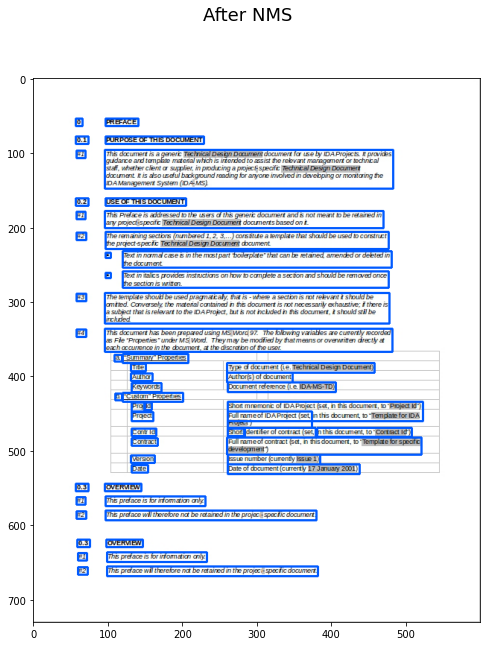

In [11]:
display_image(img_copy, 'After NMS')

# Layout Parsing

Layout-Parser is a unified toolkit for Deep Learning Based Document Image Analysis

In [12]:
%%capture
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install layoutparser
# !pip install "layoutparser[layoutmodels]"
# !pip install "layoutparser[ocr]"

In [13]:
image = np.array(doc)

In [14]:
import layoutparser as lp

In [15]:
model = lp.Detectron2LayoutModel(
    'lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config', 
    extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
    label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"}
)
# Load the deep layout model from the layoutparser API 
# For all the supported model, please check the Model 
# Zoo Page: https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html

config.yml?dl=1: 8.19kB [00:01, 7.71kB/s]
model_final.pth?dl=1: 330MB [00:04, 79.1MB/s]                          


/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


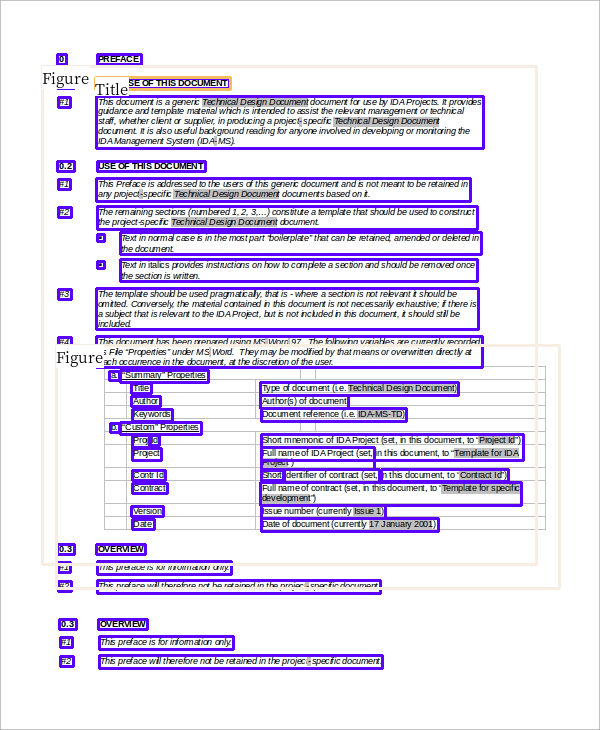

In [16]:
layout = model.detect(image)
lp.draw_box(image, layout, box_width=3, show_element_type=True)